In [84]:
import pandas as pd
import quandl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import sklearn

import pandas_datareader.data as web

from scipy.optimize import minimize

#Import to install modules
import sys

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.tsa.ar_model as AR

from itertools import product
from tqdm import tqdm_notebook

from sklearn import metrics

import yfinance as yf

import datetime

#%matplotlib inline

In [57]:
#!{sys.executable} -m pip install yfinance

In [46]:
#importing Tesla (TSLA) financial data from quandl
tesla = quandl.get('WIKI/TSLA')

#importing GM (GM) financial data from quandl
gm = quandl.get('WIKI/GM')
#gm.head(5)

#importing Apple (APPL) data from quandl
apple = quandl.get('WIKI/AAPL')

#importing Microsoft (MSFT) data from quandl
microsoft = quandl.get('WIKI/MSFT')

In [ ]:
def adjust_data(stock_data):
    for i in range(len(stock_data)):
        

In [95]:
print(gm.index[0])
for i in range(len(tesla.index)):
    print(tesla['Date'][i])
print(tesla)
print(gm)

2010-11-18 00:00:00
2010-06-29 00:00:00
2010-06-30 00:00:00
2010-07-01 00:00:00
2010-07-02 00:00:00
2010-07-06 00:00:00
2010-07-07 00:00:00
2010-07-08 00:00:00
2010-07-09 00:00:00
2010-07-12 00:00:00
2010-07-13 00:00:00
2010-07-14 00:00:00
2010-07-15 00:00:00
2010-07-16 00:00:00
2010-07-19 00:00:00
2010-07-20 00:00:00
2010-07-21 00:00:00
2010-07-22 00:00:00
2010-07-23 00:00:00
2010-07-26 00:00:00
2010-07-27 00:00:00
2010-07-28 00:00:00
2010-07-29 00:00:00
2010-07-30 00:00:00
2010-08-02 00:00:00
2010-08-03 00:00:00
2010-08-04 00:00:00
2010-08-05 00:00:00
2010-08-06 00:00:00
2010-08-09 00:00:00
2010-08-10 00:00:00
2010-08-11 00:00:00
2010-08-12 00:00:00
2010-08-13 00:00:00
2010-08-16 00:00:00
2010-08-17 00:00:00
2010-08-18 00:00:00
2010-08-19 00:00:00
2010-08-20 00:00:00
2010-08-23 00:00:00
2010-08-24 00:00:00
2010-08-25 00:00:00
2010-08-26 00:00:00
2010-08-27 00:00:00
2010-08-30 00:00:00
2010-08-31 00:00:00
2010-09-01 00:00:00
2010-09-02 00:00:00
2010-09-03 00:00:00
2010-09-07 00:00:00


2016-06-21 00:00:00
2016-06-22 00:00:00
2016-06-23 00:00:00
2016-06-24 00:00:00
2016-06-27 00:00:00
2016-06-28 00:00:00
2016-06-29 00:00:00
2016-06-30 00:00:00
2016-07-01 00:00:00
2016-07-05 00:00:00
2016-07-06 00:00:00
2016-07-07 00:00:00
2016-07-08 00:00:00
2016-07-11 00:00:00
2016-07-12 00:00:00
2016-07-13 00:00:00
2016-07-14 00:00:00
2016-07-15 00:00:00
2016-07-18 00:00:00
2016-07-19 00:00:00
2016-07-20 00:00:00
2016-07-21 00:00:00
2016-07-22 00:00:00
2016-07-25 00:00:00
2016-07-26 00:00:00
2016-07-27 00:00:00
2016-07-28 00:00:00
2016-07-29 00:00:00
2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00
2016-08-04 00:00:00
2016-08-05 00:00:00
2016-08-08 00:00:00
2016-08-09 00:00:00
2016-08-10 00:00:00
2016-08-11 00:00:00
2016-08-12 00:00:00
2016-08-15 00:00:00
2016-08-16 00:00:00
2016-08-17 00:00:00
2016-08-18 00:00:00
2016-08-19 00:00:00
2016-08-22 00:00:00
2016-08-23 00:00:00
2016-08-24 00:00:00
2016-08-25 00:00:00
2016-08-26 00:00:00
2016-08-29 00:00:00
2016-08-30 00:00:00


KeyError: 'Date'

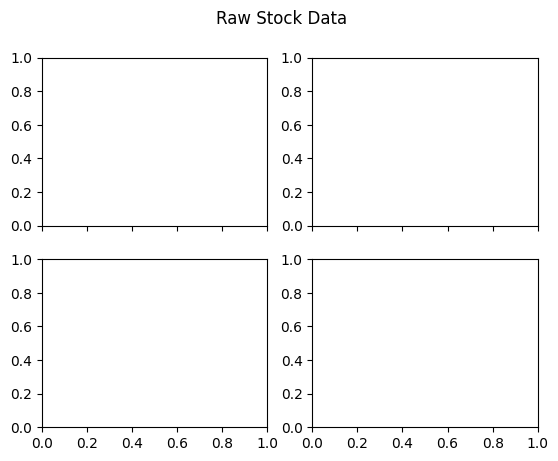

In [94]:
fig, raw_stock_plots = plt.subplots(2,2, sharex=True)
fig.suptitle('Raw Stock Data')

raw_stock_plots[0,0].plot(gm['Date'], gm['Adj. Close'], 'b')
raw_stock_plots[0,0].set_title('GM Stock Price')

raw_stock_plots[0,1].plot(tesla.index, tesla['Adj. Close'], 'r')
raw_stock_plots[0,1].set_title('TSLA Stock Price')

raw_stock_plots[1,0].plot(apple.index, apple['Adj. Close'], 'g')
raw_stock_plots[1,0].set_title('AAPL Stock Price')

raw_stock_plots[1,1].plot(microsoft.index, microsoft['Adj. Close'], 'y')
raw_stock_plots[1,1].set_title('MSFT Stock Price')

for ax in raw_stock_plots.flat:
    ax.set(xlabel='Year', ylabel='Price ($)')
    
# for ax in raw_stock_plots.flat:
#     ax.label_outer()

In [49]:
#Yearly average number of shares outstanding for TSLA and GM extraced from Quandl

tesla_shares = {
    2018: 0.859e9, 2017: 0.82575e9, 2016: 0.717e9, 2015: 0.63725e9, 2014: 0.6215e9, 
    2013: 0.6295e9, 2012: 0.52875e9, 2011: 0.518e9 , 2010: 0.1975e9}

#gm_shares = {2018:, 2017:, 2016:, 2015:, 2014:, 2013:, 2012:, 2011:, 2010:}

#yearly average number of shars outstanding for AAPL and MSFT

tesla['Year'] = tesla.index.year

print(tesla.index)

tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0

#calculate market caps by year
for i, year in enumerate(tesla['Year']):
    shares = tesla_shares.get(year)
    
    tesla.loc[i, 'cap'] = shares*tesla.loc[i, 'Adj. Close']

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27'],
              dtype='datetime64[ns]', name='Date', length=1949, freq=None)


In [11]:
#The following time series analysis example follows the analysis of mobile game data
#presented here: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

ads = pd.read_csv('/Users/elliotgolias/Documents/QuantFinance/TimeSeriesAnalysis/Data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('/Users/elliotgolias/Documents/QuantFinance/TimeSeriesAnalysis/Data/currency.csv', index_col=['Time'], parse_dates=['Time'])

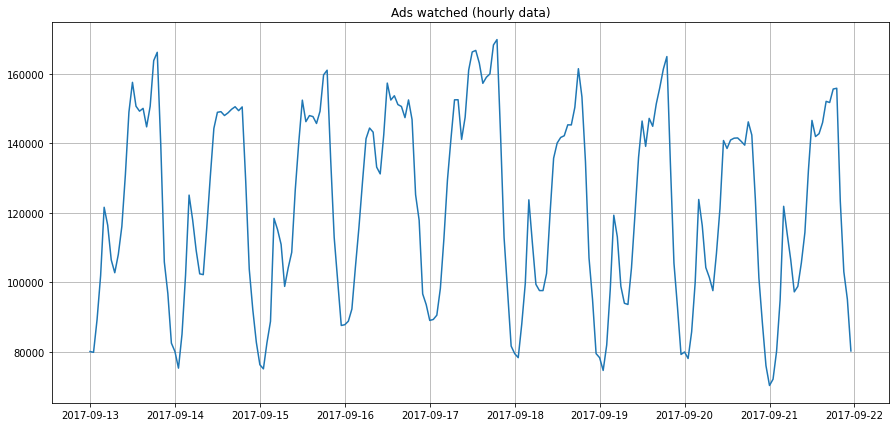

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

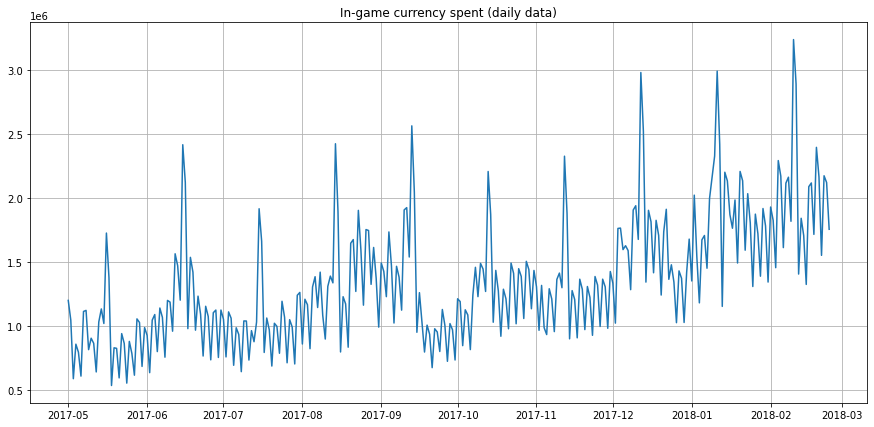

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24)

116805.0

In [21]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = sklearn.metrics.mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

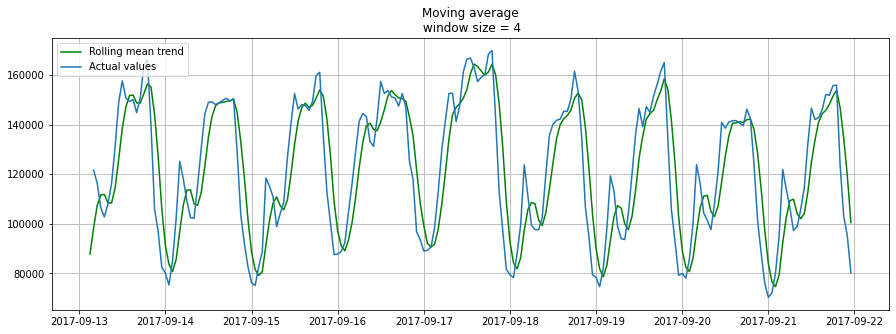

In [17]:
plotMovingAverage(ads, 4) 

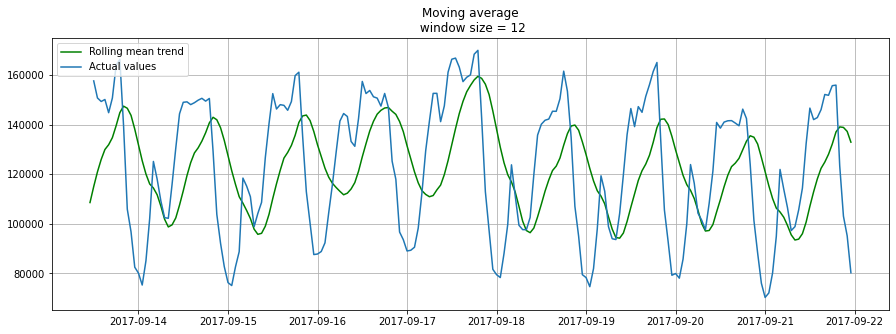

In [18]:
plotMovingAverage(ads, 12)

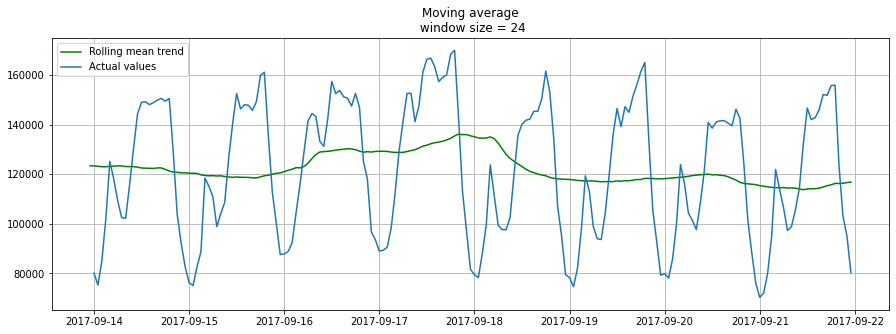

In [19]:
plotMovingAverage(ads, 24)

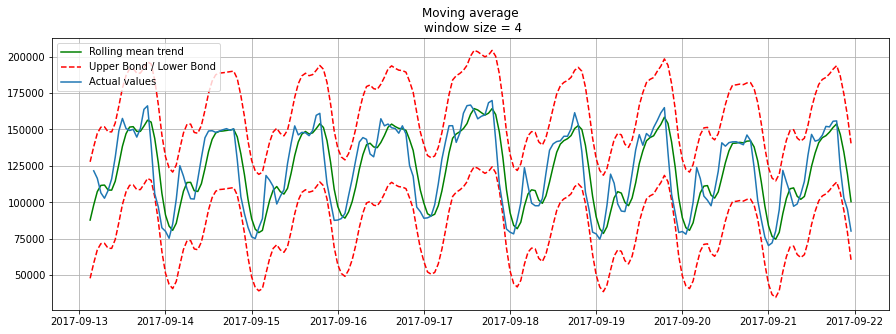

In [30]:
plotMovingAverage(ads, 4, plot_intervals=True)

In [31]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads

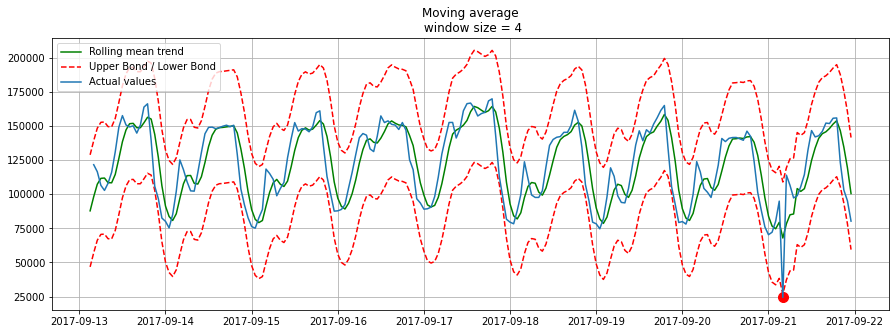

In [32]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

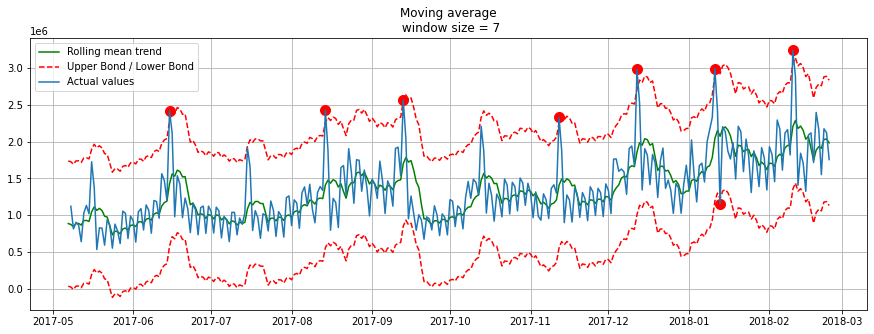

In [33]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [3]:
#Second example starts here:


end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


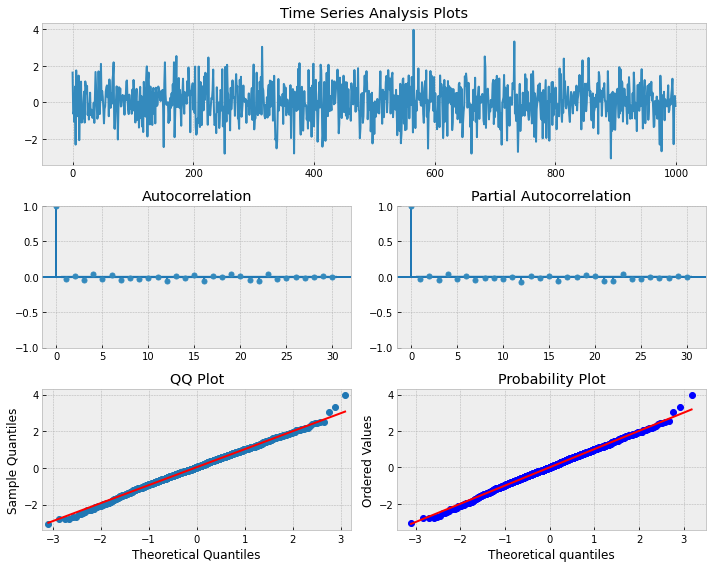

In [5]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


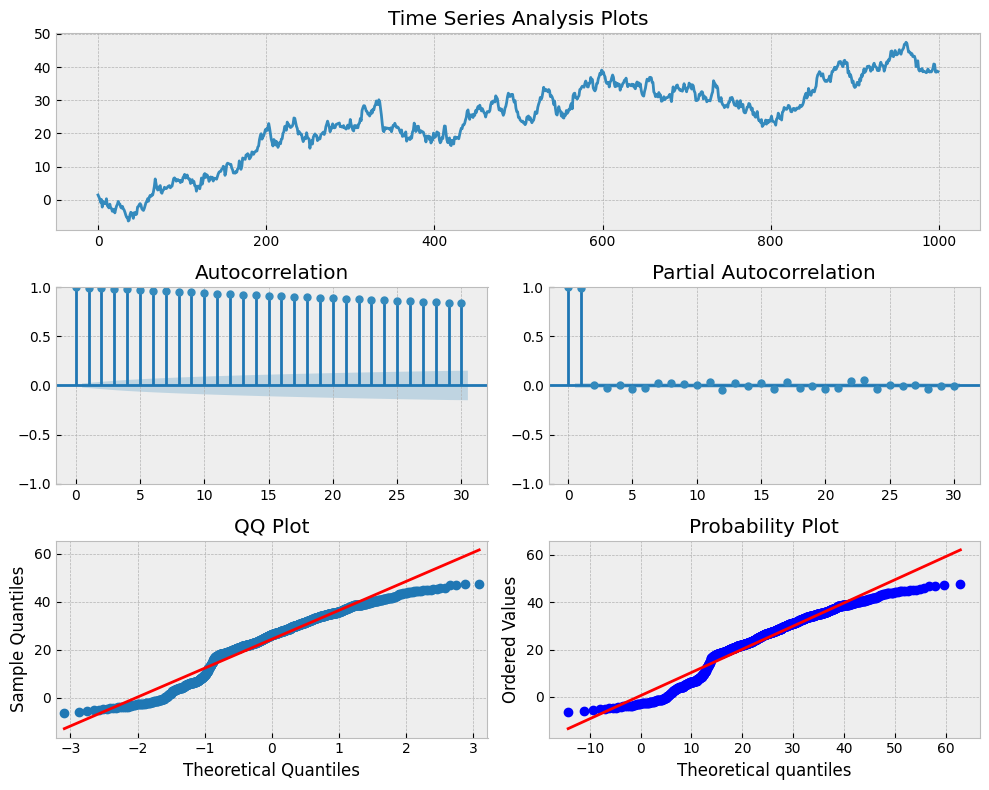

In [6]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


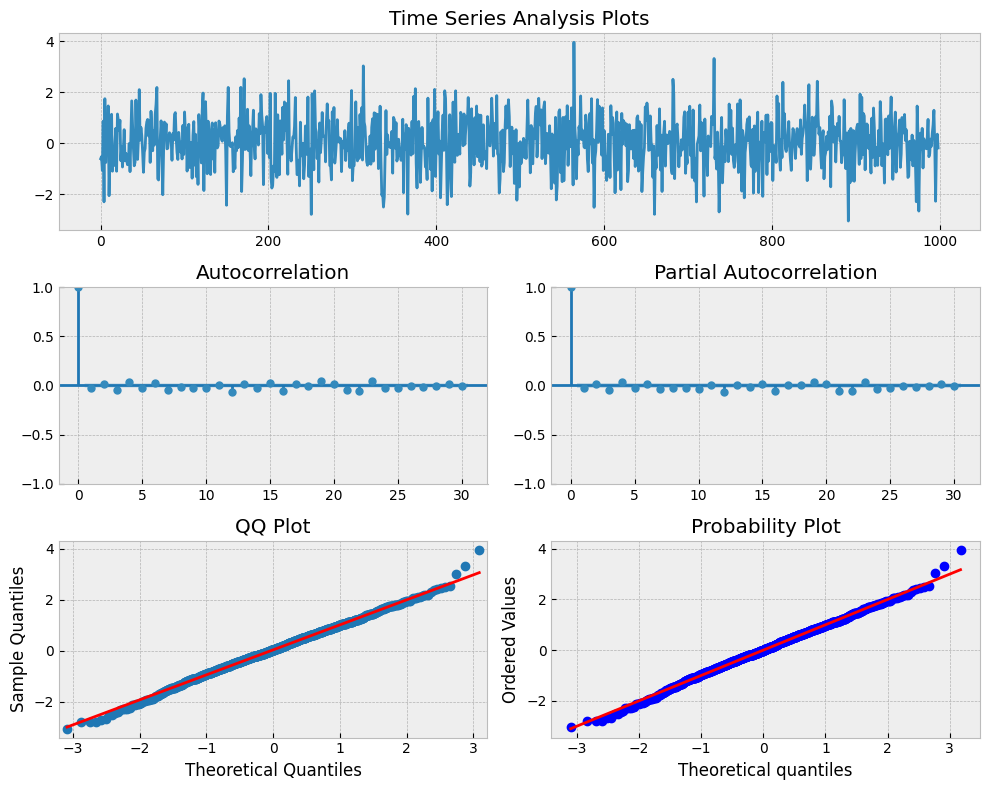

In [7]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


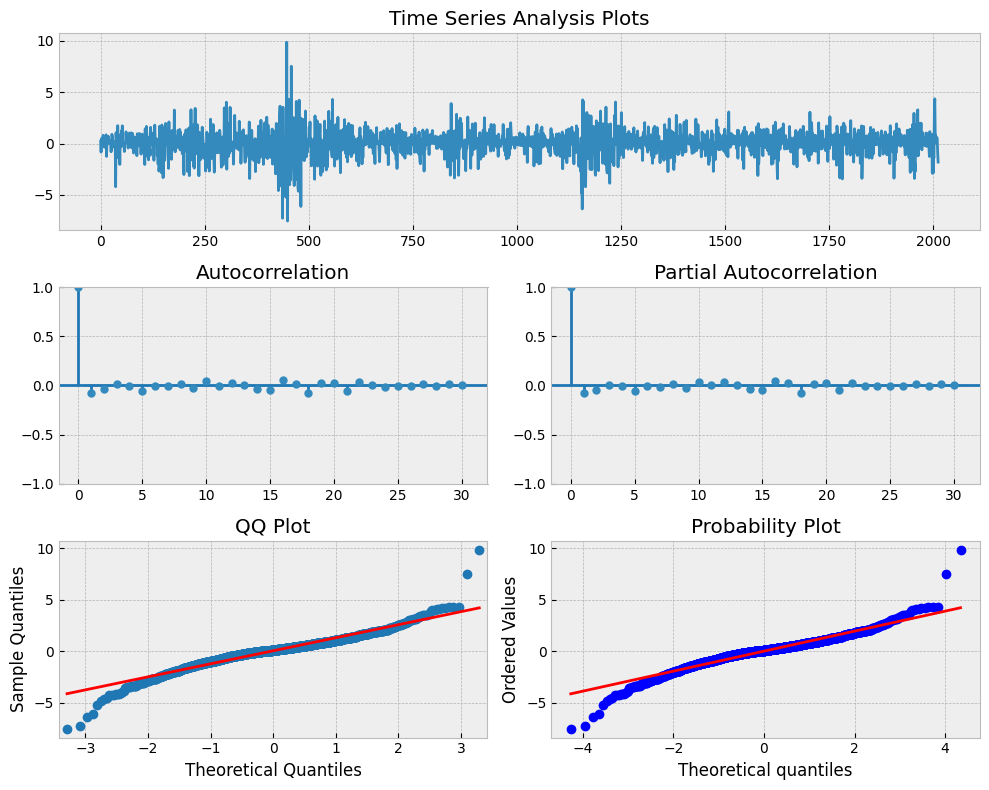

In [8]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


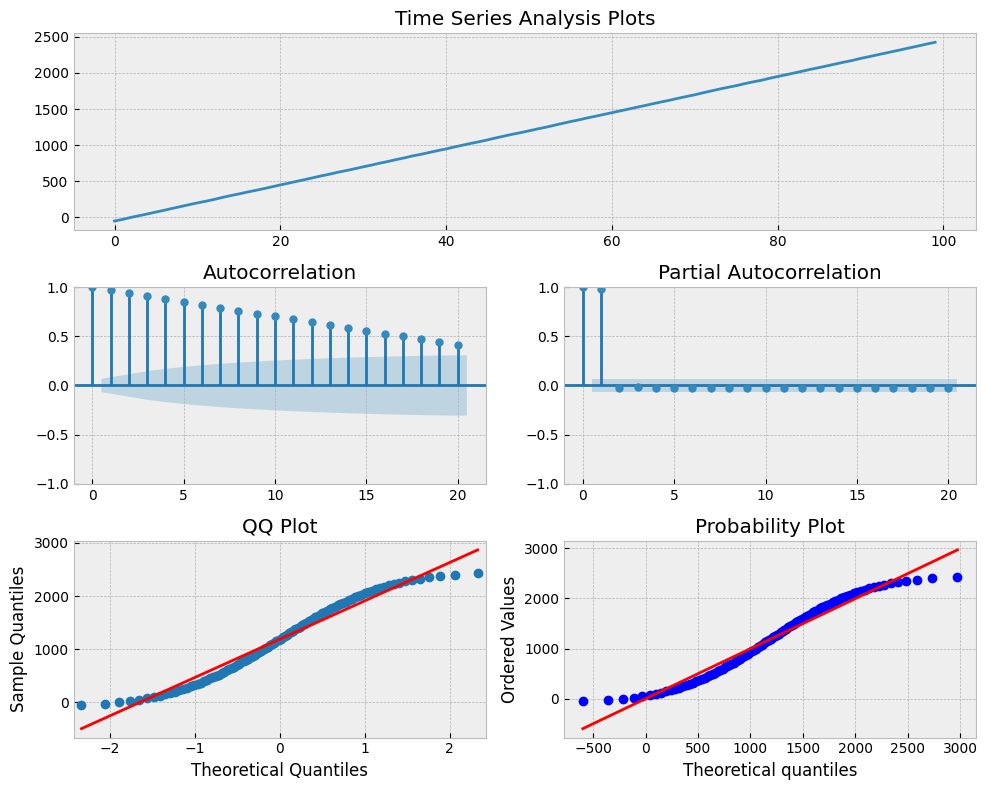

In [9]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=None) 

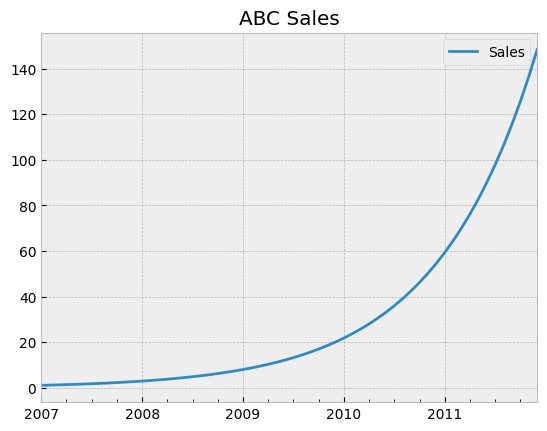

In [10]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

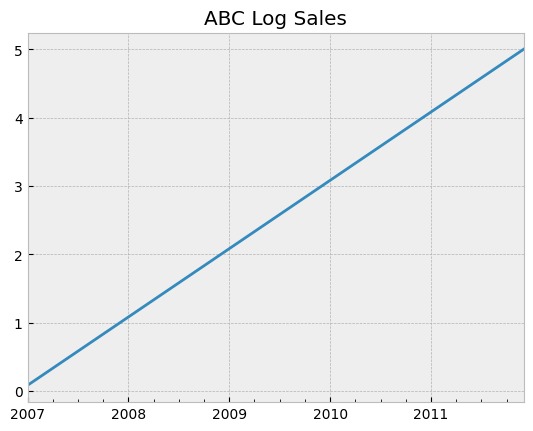

In [11]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


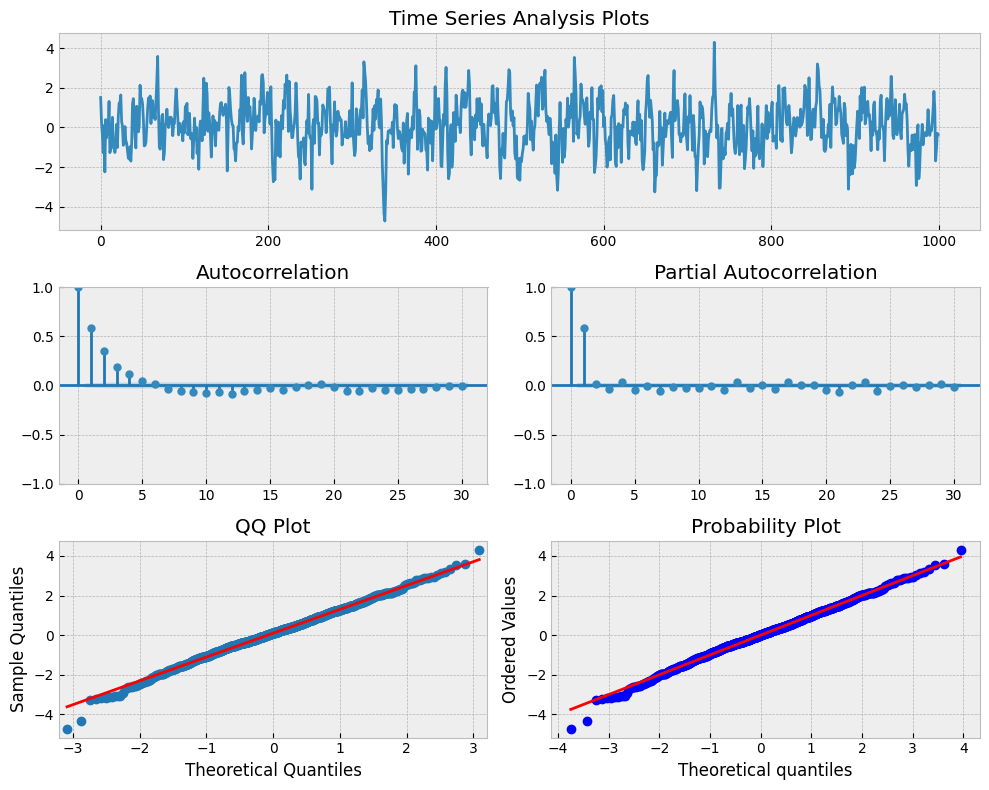

In [12]:
#Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=None)

In [13]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

#trend = 'c' is the default fitting with constant deterministic terms
mdl = AR.AutoReg(x, lags=10, trend='c').fit()
est_order = AR.ar_select_order(x, maxlag=10, ic='aic', trend='c')

results = est_order.model.fit()

print(mdl.summary())

results2 = est_order.model.fit()

print(results2.summary())

true_order = 1
print('\n AR Model First Order Parameter: {:3.5f} | best lag order = {}'.format(mdl.params[1], est_order))
print('\n Fixed First Order Parameter: = {} | true order = {}'.format(a, true_order))

#print(est_order)

#print()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                    AutoReg(10)   Log Likelihood               -1379.111
Method:               Conditional MLE   S.D. of innovations              0.974
Date:                Thu, 26 May 2022   AIC                           2782.222
Time:                        23:01:44   BIC                           2840.994
Sample:                            10   HQIC                          2804.570
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0480      0.031      1.531      0.126      -0.013       0.109
y.L1           0.5797      0.032     18.243      0.000       0.517       0.642
y.L2           0.0187      0.037      0.510      0.6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


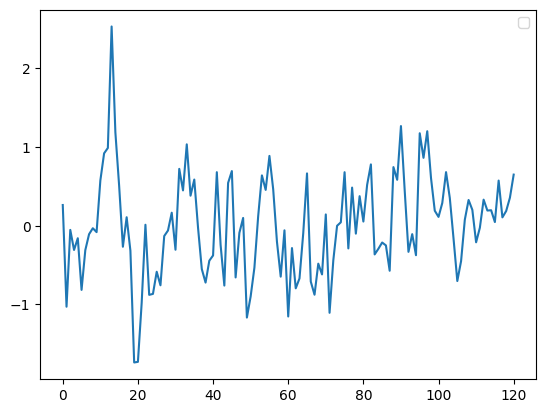

In [16]:
fig = results.plot_predict(720, 840)

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


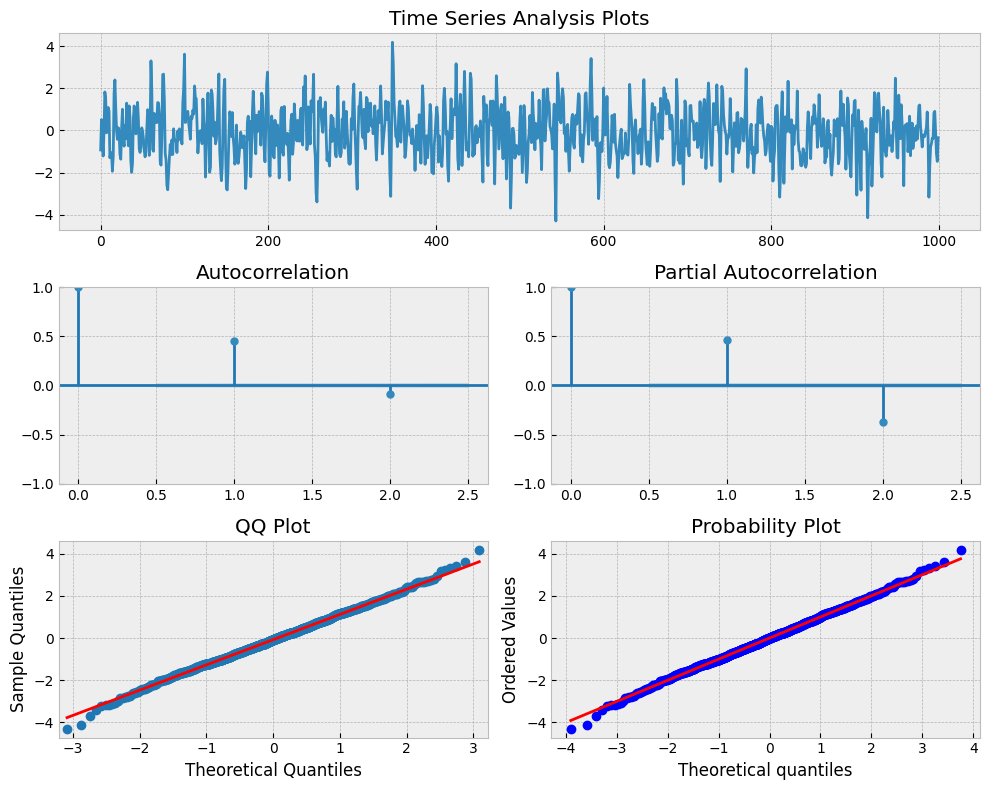

In [26]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=2)

In [31]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = AR.AutoReg(trend=n).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = AR.AutoReg(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2

TypeError: __init__() missing 2 required positional arguments: 'endog' and 'lags'

In [22]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

NotImplementedError: AR has been removed from statsmodels and replaced with statsmodels.tsa.ar_model.AutoReg.

/Users/elliotgolias/Documents/QuantFinance/Twitter-Sentiment-Analysis/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


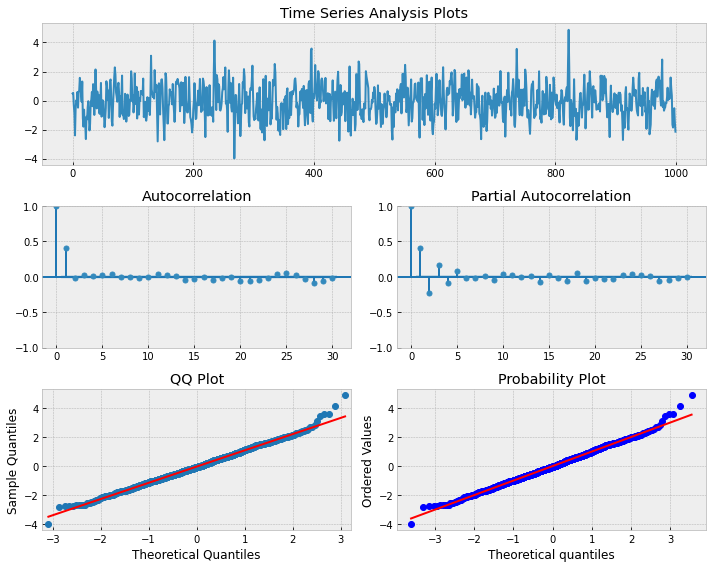

In [23]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [24]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

AttributeError: module 'statsmodels.tsa.api' has no attribute 'ARMA'

In [25]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

AttributeError: module 'statsmodels.tsa.api' has no attribute 'ARMA'